In [1]:
# Data management
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context='talk', palette='rainbow')
import missingno as msno
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Load

In [2]:
# VAERSData
data = pd.read_csv('data/2021VAERSData.csv', index_col=0, encoding='latin-1')
print(f'VAERSData\thas: {data.shape[0]} rows y {data.shape[1]} columns.')

# VAERSVAX
vax = pd.read_csv('data/2021VAERSVAX.csv', index_col=0, encoding='latin-1')
print(f'VAERSVAX\thas: {vax.shape[0]} rows y {vax.shape[1]} columns.')

# VAERSSymptoms
symptom = pd.read_csv('data/2021VAERSSYMPTOMS.csv', index_col=0, encoding='latin-1')
print(f'VAERSSymptoms\thas: {symptom.shape[0]} rows y {symptom.shape[1]} columns.')

VAERSData	has: 747180 rows y 34 columns.
VAERSVAX	has: 791183 rows y 7 columns.
VAERSSymptoms	has: 999509 rows y 10 columns.


# **Filters**

## **1. VAERSVAX** - COVID19, known manufacter

In [3]:
# maintain COVID19, known manufacter
vax = vax.loc[(vax['VAX_MANU'] != 'UNKNOWN MANUFACTURER') & (vax['VAX_TYPE'] == 'COVID19')] 
# remove repetitive information
vax = vax.loc[vax.index.drop_duplicates(keep=False)]
vax.drop(columns = ['VAX_NAME', 'VAX_TYPE'], inplace = True)
print(f'VAERSVAX\thas: {vax.shape[0]} rows y {vax.shape[1]} columns.')

VAERSVAX	has: 674116 rows y 5 columns.


## **2.** Merge **VAERVAX** and **VAERSData**

In [4]:
covid = pd.merge(vax, data, on='VAERS_ID')
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 674116 observations y 39 columns


## **3.** Removed useless variables

- **RPT_DATE** -- better report date.
- **SPLTTYPE** -- manufacter project.
- **TODAYS_DATE** -- upload report date.
- **V_FUNDBY** -- insuficient data
- **ER_VISIT** -- empty
- **BIRTH_DEFECT,X_STAY** -- insuficient data
- **NUMDAYS** -- data with to many errors

In [5]:
## Remove
rejected_col = ['RPT_DATE', 'SPLTTYPE', 'TODAYS_DATE', 'V_FUNDBY', 'ER_VISIT', 'BIRTH_DEFECT','X_STAY', 'NUMDAYS']
covid.drop(rejected_col, axis=1, inplace=True)
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 674116 observations y 31 columns


## **4.** Drop **FORM_VERS** == 1 
(mailing version of VAERS)

In [6]:
# Dropping PDF - emailed version
covid = covid.loc[covid.FORM_VERS == 2]
covid.drop(columns= 'FORM_VERS', inplace=True) # not required after filter
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 673705 observations y 30 columns


## **5.** Short Analysis of **VAX_DOSE_SERIES**, individuals more than 3 dosis were excluded

In [7]:
# Analysis of outliers 
covid['VAX_DOSE_SERIES'] = covid['VAX_DOSE_SERIES'].str.lower().replace('unk', np.nan)
# Outliers
outliers_dosis = covid.loc[covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]

print(f'OUTLIERS (3+ inoculatoins):')
print(outliers_dosis.groupby(['VAX_MANU']).size())
print(f'\nDEADS:')
print(outliers_dosis.groupby(['VAX_MANU', 'DIED']).size())
print(f'\nHOSPITALIZACIONS:')
print(outliers_dosis.groupby(['VAX_MANU', 'HOSPITAL']).size())


OUTLIERS (3+ inoculatoins):
VAX_MANU
JANSSEN             78
MODERNA            546
PFIZER\BIONTECH    397
dtype: int64

DEADS:
VAX_MANU         DIED
MODERNA          Y       10
PFIZER\BIONTECH  Y        2
dtype: int64

HOSPITALIZACIONS:
VAX_MANU         HOSPITAL
JANSSEN          Y            4
MODERNA          Y           15
PFIZER\BIONTECH  Y            7
dtype: int64


In [8]:
# Filtering
covid = covid[~covid['VAX_DOSE_SERIES'].isin(['4', '5', '6', '7+'])]
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 672684 observations y 30 columns


We asume that every report has at least 1 dose, so we replace nan values to 1

In [9]:
covid.VAX_DOSE_SERIES.fillna(1, inplace =True)
covid.VAX_DOSE_SERIES = covid.VAX_DOSE_SERIES.astype(int)

## **6.** Fixing US **STATES**, any other territory webt t

In [10]:
# Fixing state
covid['STATE'] = covid['STATE'].str.upper()
covid['STATE'] = covid['STATE'].str.strip()

# Replace US territories by OTHER
usa_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# other include the US territories list
others = list(set(covid['STATE'].value_counts().index.tolist()) - set(usa_states))
covid['STATE'] = covid['STATE'].replace(others, 'OTHER')

# coercing nan values to NSP
covid['STATE'] = covid['STATE'].fillna('NSP')

## **7. AGE_YRS, CAGE_YR, CAGE_MO** - If the age is no stated was recoverd by CAGE** data.

In [11]:
# Age recover
print('Recovery age for ', covid.loc[~covid['CAGE_YR'].isnull()].AGE_YRS.isnull().sum(), 'observatoins not recorded')

Recovery age for  5472 observatoins not recorded


In [12]:
# fixing dtype
age_data = ['AGE_YRS', 'CAGE_YR', 'CAGE_MO']
for i in age_data:
    covid[i] = covid[i].fillna(200).astype('int')

# expecting age
covid['AGE_EXP'] = covid.CAGE_YR.astype(str) + '.' + covid.CAGE_MO.astype(str)
covid['AGE_EXP'] = covid['AGE_EXP'].astype(float).round()

# replacing
covid['AGE_YRS'] = np.where(((covid['AGE_YRS']==200)&(covid['AGE_EXP']!=200)) , covid['AGE_EXP'], covid['AGE_YRS'])

# Remove CAGE** columns
remove = ['AGE_EXP', 'CAGE_YR', 'CAGE_MO']
covid.drop(columns=remove, inplace=True)

# turning > 100 year into nan
covid = covid.loc[covid['AGE_YRS']<100,]

print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 28 columns


## **8. SEX** - Remove Unknown sex records.

In [160]:
covid = covid.loc[covid['SEX'] != 'U']
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 604451 observations y 31 columns


## **9. ER_ED_VISIT, OFC_VISIT** - turn into binary in ER_VISIT

In [13]:
# filling na to manage the data
ER = ['ER_ED_VISIT', 'OFC_VISIT']
for i in ER:
    covid[i] = covid[i].str.replace('Y', '1')
    covid[i].fillna('0', inplace=True)
    covid[i] = covid[i].astype(int)

# merging
covid['ERD_VISIT'] = covid['ER_ED_VISIT'] + covid['OFC_VISIT']

# turning binary
covid['ERD_VISIT'] = np.where(covid['ERD_VISIT'] >= 1, 1, 0)

# removing extra columns
covid.drop(columns=ER, inplace=True)

print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **10. HOSPITAL, HOSPDAYS** - Filter, up to 120 days at hospitalization.

In [14]:
# filling na to manage the data
HO = ['HOSPITAL', 'HOSPDAYS']
for i in HO:
    covid[i].fillna('0', inplace=True)

# Turn HOSPITAL in binary
covid.HOSPITAL.replace('Y','1', inplace=True)

# Turn values into numeric
for i in HO:
    covid[i] = covid[i].astype(int)

# Turning values upper to 120 to 0
covid.HOSPDAYS = np.where(covid.HOSPDAYS > 120, 0, covid.HOSPDAYS)

In [15]:
# Review valores
A = (covid.HOSPDAYS != 0) & (covid.HOSPITAL != 0)
B = (covid.HOSPDAYS == 0) & (covid.HOSPITAL != 0)
C = (covid.HOSPDAYS != 0) & (covid.HOSPITAL == 0)

print('Pacients hospitalized (Y)\t\t:', (covid.HOSPITAL != 0).sum())
print('At least 1 day in hospitalization\t:', (covid.HOSPDAYS != 0).sum())
print(f'HOSPDAYS (True) y HOSPITAL (True)\t: {covid.loc[A].shape[0]}')
print(f'HOSPDAYS (False) y HOSPITAL (True)\t: {covid.loc[B].shape[0]}')
print(f'HOSPDAYS (True) y HOSPITAL (False)\t: {covid.loc[C].shape[0]}')

Pacients hospitalized (Y)		: 36807
At least 1 day in hospitalization	: 26097
HOSPDAYS (True) y HOSPITAL (True)	: 26097
HOSPDAYS (False) y HOSPITAL (True)	: 10710
HOSPDAYS (True) y HOSPITAL (False)	: 0


In [16]:
# Replacing HOSPDAYS -- asuming that if it is Hospitalize at least 1 day.
covid['HOSPDAYS'] = np.where(B, 1, covid['HOSPDAYS'])

print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **11. L_THREAT** - Binary

In [17]:
# Turning binary
covid.L_THREAT.fillna('0', inplace=True)
covid.L_THREAT.replace('Y', 1, inplace=True)
covid.L_THREAT = covid.L_THREAT.astype(int)
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **12. DISABLE** - Binary

In [18]:
# Turning binary
covid.DISABLE.fillna('0', inplace=True)
covid.DISABLE.replace('Y', 1, inplace=True)
covid.DISABLE = covid.DISABLE.astype(int)
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **13. RECOVD** - replace nan values for 'U'

In [19]:
# Turning nan unto U
covid.RECOVD.fillna('U', inplace=True)
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **14. V_ADMINBY** - Fixing string names.

In [20]:
covid.V_ADMINBY = covid.V_ADMINBY.str.upper()
print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **15. VAX_LOT, VAX_ROUTE, VAX_SITE**

In [21]:
# ficing string and removing Unknow data
VX = ['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE']
for i in VX:
    covid[i].fillna('UNKNOWN', inplace=True)
    covid[i] = covid[i].str.upper()
    covid[i] = covid[i].str.strip()

print(f'Covid dataset \thas: {covid.shape[0]} observations y {covid.shape[1]} columns')

Covid dataset 	has: 609988 observations y 27 columns


## **16. DIED** Binary

In [22]:
# DIED into binary
covid.DIED.fillna('0', inplace=True)
covid.DIED.replace('Y', 1, inplace=True)

# Fixing by condition DATEDIED (True) and DIED (False)
covid.DIED = np.where(covid.DATEDIED.notna(), 1, covid.DIED)

## **17. RECVDATE, DATEDIED, VAX_DATE, ONSET_DATE** Format

In [23]:
# datetime format
DT = ['RECVDATE', 'DATEDIED', 'VAX_DATE', 'ONSET_DATE']
for i in DT:
    # datetime format
    covid[i] =  covid[i].apply(pd.to_datetime, format='%m/%d/%Y')

    if i == 'RECVDATE': 
        continue
    else: 
        # removing errors, first vaccine was in Dec 14th, 2020
        condition = covid[i] < pd.Timestamp(2020,12,10)
        covid[i][condition] = pd.NaT

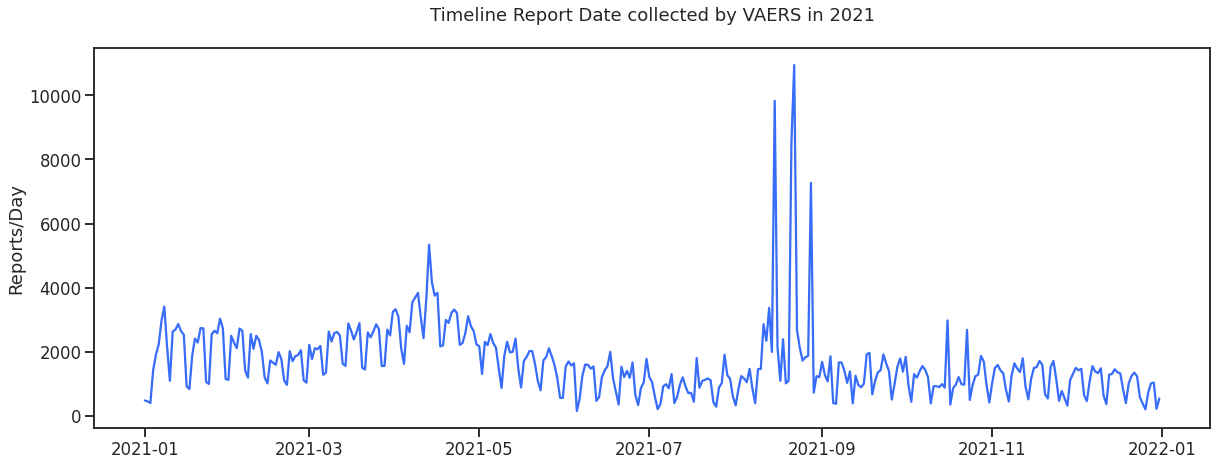

In [24]:
# Plot for RECVDATE
plt.figure(figsize=(20,7))
sns.lineplot(data = covid['RECVDATE'].value_counts())
plt.ylabel('Reports/Day')
plt.title('Timeline Report Date collected by VAERS in 2021\n')
plt.show()

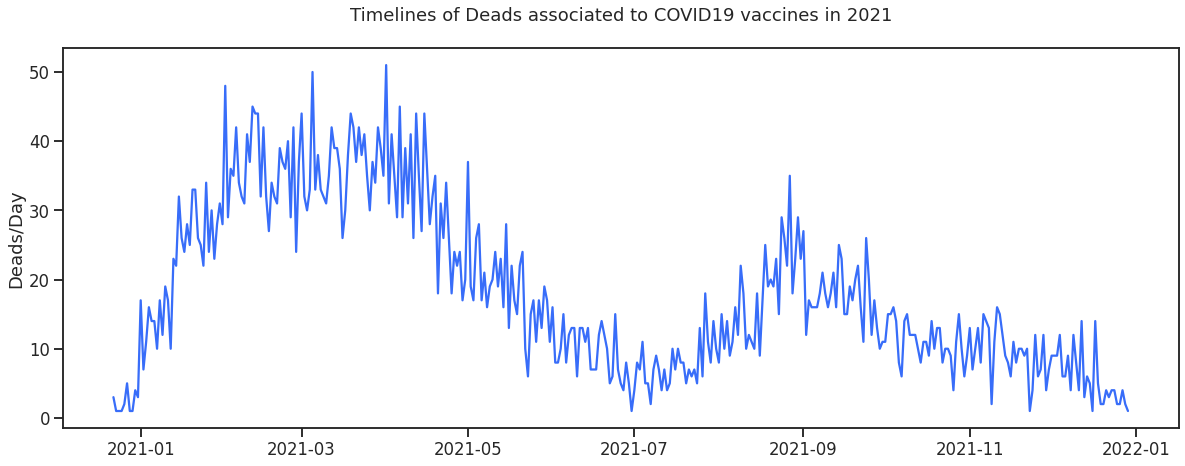

In [25]:
# Plot for DATEDIED
plt.figure(figsize=(20,7))
sns.lineplot(data = covid['DATEDIED'].value_counts())
plt.ylabel('Deads/Day')
plt.title('Timelines of Deads associated to COVID19 vaccines in 2021\n')
plt.show()

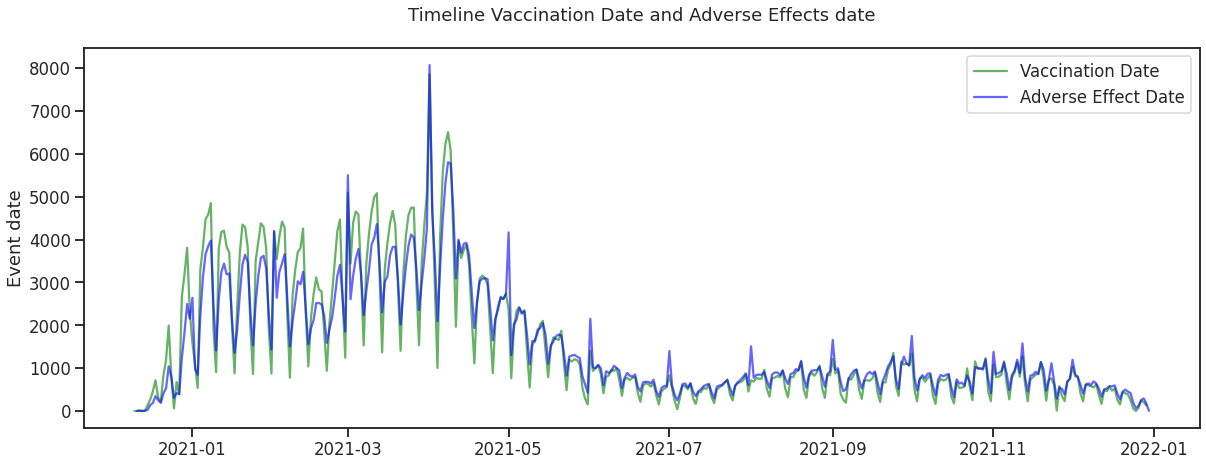

In [26]:
# Plot for VAX_DATE and ONSET_DATE
fig,ax = plt.subplots(1,figsize=(20,7))
sns.lineplot(data = covid.VAX_DATE.value_counts(),ax=ax, label='Vaccination Date', alpha=0.6, color='green')
sns.lineplot(data = covid.ONSET_DATE.value_counts(),ax=ax,label=str('Adverse Effect Date'), alpha=0.6, color='blue')
plt.legend()
plt.ylabel('Event date')
plt.title('Timeline Vaccination Date and Adverse Effects date\n')
plt.show()

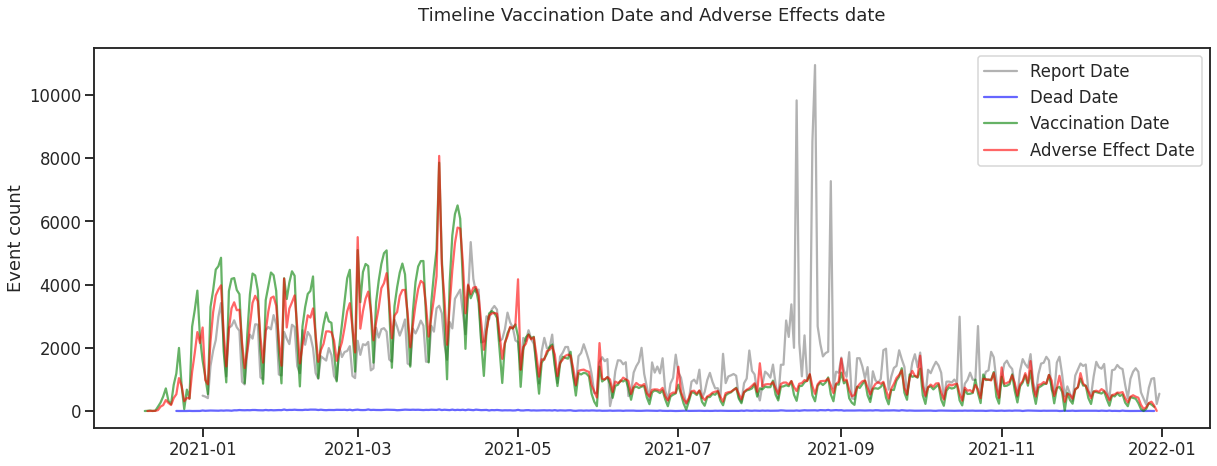

In [27]:
# Dates plot
fig,ax = plt.subplots(1,figsize=(20,7))
sns.lineplot(data = covid['RECVDATE'].value_counts(),ax=ax, label='Report Date', alpha=0.6, color='grey')
sns.lineplot(data = covid['DATEDIED'].value_counts(),ax=ax, label='Dead Date', alpha=0.6, color='blue')
sns.lineplot(data = covid.VAX_DATE.value_counts(),ax=ax, label='Vaccination Date', alpha=0.6, color='green')
sns.lineplot(data = covid.ONSET_DATE.value_counts(),ax=ax,label=str('Adverse Effect Date'), alpha=0.6, color='red')
plt.legend()
plt.ylabel('Event count')
plt.title('Timeline Vaccination Date and Adverse Effects date\n')
plt.show()

# **Final revision**

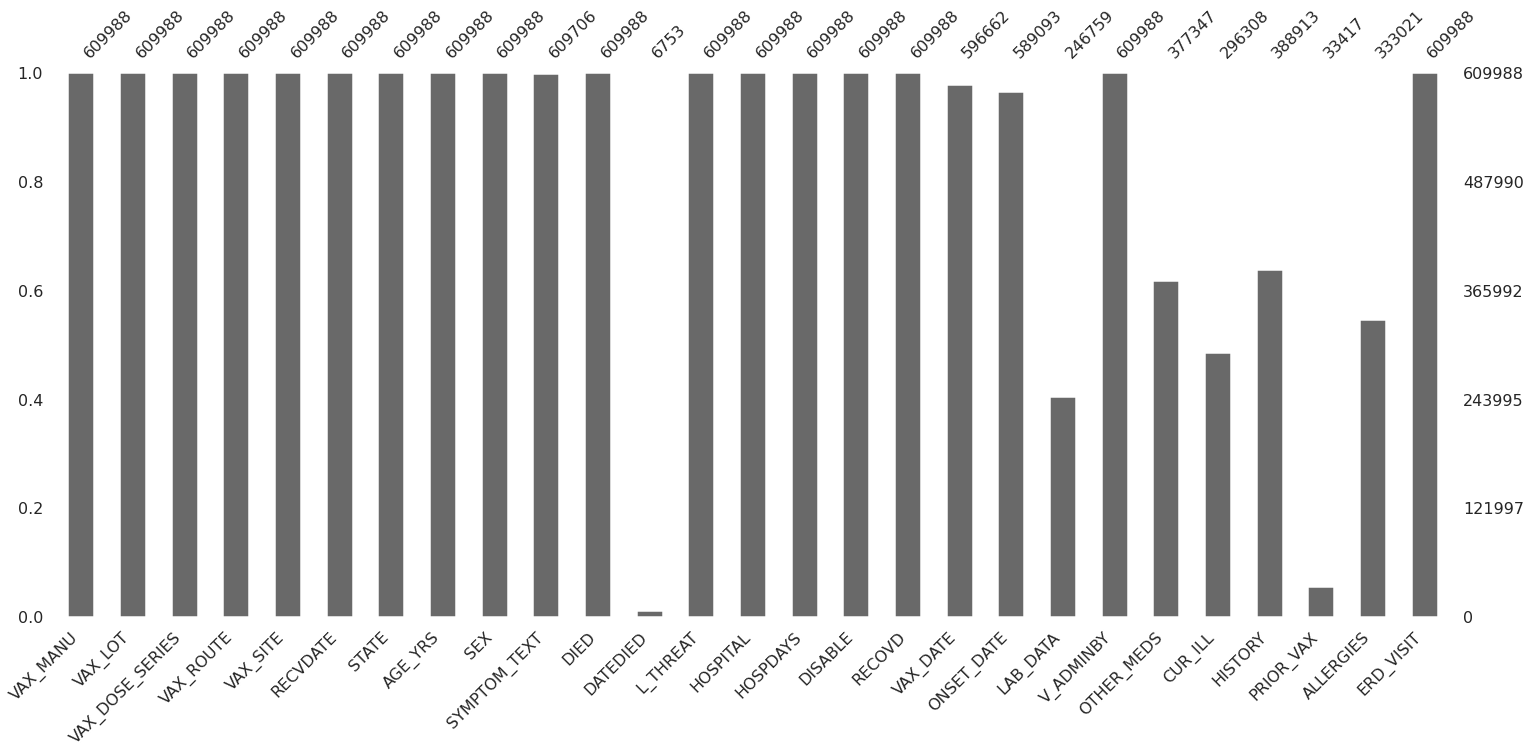

In [28]:
msno.bar(covid)
plt.show()

In [29]:
# order columns
col_order = ['RECVDATE', 'VAX_LOT', 'VAX_MANU', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'V_ADMINBY', 'STATE', 'AGE_YRS', 'SEX', 'RECOVD', 'DISABLE', 'L_THREAT', 'VAX_DATE', 'ONSET_DATE', 'ERD_VISIT', 'HOSPITAL', 'HOSPDAYS', 'DIED', 'DATEDIED', 'SYMPTOM_TEXT', 'LAB_DATA', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES']

covid = covid[col_order]

In [30]:
# Export cleaner database
covid.to_csv("dbclean/covid19_VAERSdb.csv")

### Subsetting the data for study

In [31]:
# filter
criteria = (covid.VAX_MANU == 'PFIZER\BIONTECH') & (covid.HOSPITAL == 1)
covid = covid.loc[criteria]

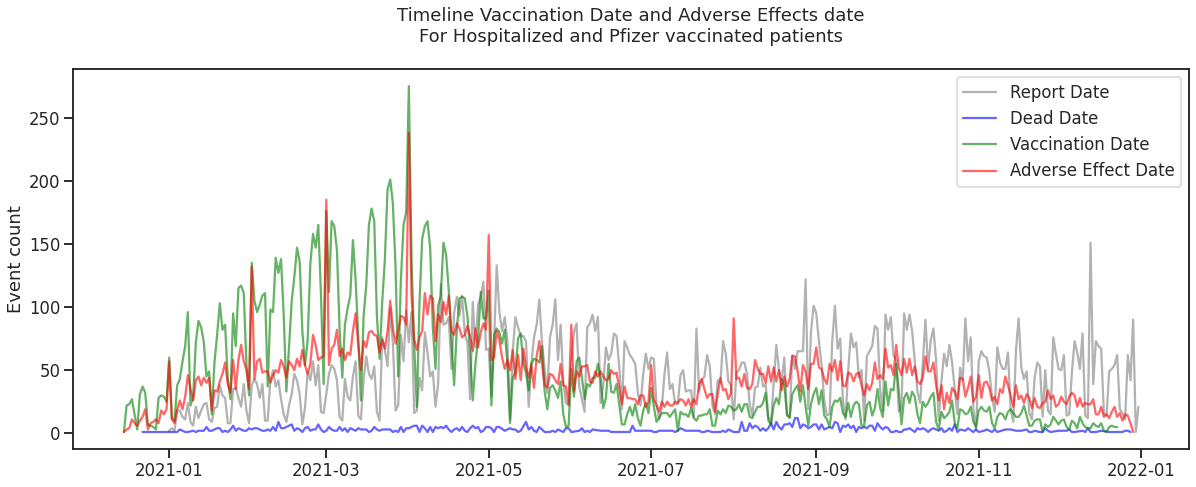

In [32]:
# grafico de todas las fechas
fig,ax = plt.subplots(1,figsize=(20,7))
sns.lineplot(data = covid.RECVDATE.value_counts(),ax=ax, label='Report Date', alpha=0.6, color='grey')
sns.lineplot(data = covid.DATEDIED.value_counts(),ax=ax, label='Dead Date', alpha=0.6, color='blue')
sns.lineplot(data = covid.VAX_DATE.value_counts(),ax=ax, label='Vaccination Date', alpha=0.6, color='green')
sns.lineplot(data = covid.ONSET_DATE.value_counts(),ax=ax,label=str('Adverse Effect Date'), alpha=0.6, color='red')
plt.legend()
ax.set_ylabel('Event count')
plt.title('Timeline Vaccination Date and Adverse Effects date\nFor Hospitalized and Pfizer vaccinated patients\n')
plt.show()

In [33]:
# guardamos el dataset
covid.to_csv("dbclean/covid19_VAERS-HospPfizer.csv")